## LINK TO REPORT

In [ ]:
https:/github.com/Antonio141/Coursera_Capstone/blob/master/report.pdf


## LINK TO PRESENTATION


In [1]:
https:/github.com/Antonio141/Coursera_Capstone/blob/master/CAPSTONE%20PROJECT%20%20.pdf


SyntaxError: invalid syntax (&lt;ipython-input-1-8d991332efb9&gt;, line 1)

# SEVERITY PREDICTION REPORT 

## BUSINESS UNDERSTANDING
This work aims to develop a model capable of predicting the severity of an accident given the conditions circumstancial to the episode.
The model is trained over a dataset containing the conditions of traffic, light, weather etc... present at the moment of the accident.
Such model will then be trained to predict severity given these conditions so to allow the interested entities to be prepared and act fast for when an emergency comes.


## DATA UNDERSTANDING
This phase consists of different steps of work on the data:

    1. Selecting the column that tracks the description of the accident's severity 'SEVERITYCODE'
    2. Select the most important features that may influence the final result:
        - Road, Light and Weather Conditions ('ROADCOND', 'LIGHTCOND', 'WEATHER')
        - The city district in which the accident happened, obtained from the coordinates columns ('X','Y')
        - The kind of spot in which the accident took place as 'Interception', 'Block', 'Alley' ('ADDRTYPE')
        - The number of people, pedons and cyclists involved ('PEDCOUNT', 'PERSONCOUNT', 'PEDCYLCOUNT')
        - The day of the week in which the accident took place ('INCDATE')
    3. Adjust the data format changing from text to numerical values 
    4. Take care of the NaN values spread around the dataframe
    4. Remove the duplicates columns and the ones that don't contribute in any way to the model development
    5. Check for columns with strong correlation between each other so to clear and simplify the dataset
     

### Extraction and preparation of data 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('D:/personale/MACHINELEARNING/IBM/capstone/Data-Collisions.csv')

### Choropleth Map 
Extraction of set of coordinates and classification of each accident to the corresponding city's district

In [2]:
import json,folium 
import shapely
from shapely.geometry import Point, Polygon
import shapely.speedups
import geopandas


gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.X, df.Y))

shapely.speedups.enable()

a = open('D:/personale/MACHINELEARNING/IBM/python for machine learning/Final Project/seattle_districts.json')

f = json.load(a)

# Preparation of DISTRICT column
df['DISTRICT'] = np.nan

for i in range(7):
    distr= f['features'][i]['geometry']['coordinates']
    d = []
    for j in range(len(distr[0])):
        d.append(distr[0][j]) 
    
    D = Polygon(d)

    r= np.where(gdf['geometry'].within(D))[0]
    df['DISTRICT'][r] = i

Analysis of number of incidents per district 

In [3]:
df.groupby('DISTRICT')['SEVERITYCODE'].value_counts()

DISTRICT  SEVERITYCODE
0.0       1               14287
          2                5989
1.0       1               27155
          2               12043
2.0       1               21695
          2                8500
3.0       1               14311
          2                5963
4.0       1               12725
          2                7107
5.0       1               14809
          2                6426
6.0       1               26424
          2               10623
Name: SEVERITYCODE, dtype: int64

In [4]:
# Preparation of dataframe with info about number of serious case incidents in each districts
dis = {'DISTRICT': [1,2,3,4,5,6,7],
        'TOTAL': [6027,11641,8975,6047,6043,6233,11111]
      }
df1 = pd.DataFrame(dis, columns = ['DISTRICT', 'TOTAL'])

Elaboration of Choropleth map to visualize the results 

In [5]:
m = folium.Map(location=[47.70314032, -122.323148],zoom_start= 11 )

m.choropleth(
    geo_data=f,
    data=df1,
    columns=['DISTRICT', 'TOTAL'],
    key_on='feature.properties.district',
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.5,
    legend_name='Accident'
)
m

&lt;folium.folium.Map at 0x24c59410&gt;

It can be noticed that in the city there are some districts that show a greater presence of critic incidents with respect to the others.
Next graph shows the distribution of the kind of accident per district. 

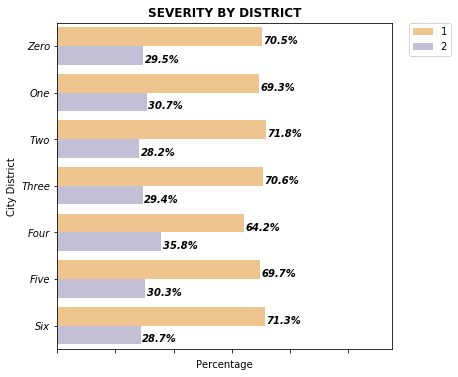

In [6]:
df['DISTRICT'].replace( \
to_replace=(0,1,2,3,4,5,6), \
value=('Zero','One','Two','Three','Four','Five','Six'), \
inplace=True)

temp= df.groupby(['DISTRICT'])['SEVERITYCODE'].value_counts(normalize=True).mul(100).rename('percentage').reset_index().sort_index()
plt.figure(figsize=(6,6))
chart = sns.barplot(data = temp, x = 'percentage', y= 'DISTRICT', hue= 'SEVERITYCODE', linewidth=2, palette='PuOr', order= ('Zero','One','Two','Three','Four','Five','Six'))
chart.set_title('SEVERITY BY DISTRICT', weight='bold')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_yticklabels(chart.get_yticklabels(), rotation=0, horizontalalignment='right', style='italic')
chart.set_xlabel('Percentage')
chart.set_ylabel('City District')
chart.set_xbound(upper=115)
# chart.set_ybound(lower=-1,upper=10)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

total=100
new_value=0.5
for p in chart.patches:
        percent = '{:.1f}%'.format(100 * p.get_width()/total)
        x =  p.get_width() + .5
        y = p.get_y() + p.get_height() - .05 
        chart.annotate(percent, (x, y), fontsize=10, color='k', weight='bold', style='italic')

df['DISTRICT'].replace( \
value=(0,1,2,3,4,5,6), \
to_replace=('Zero','One','Two','Three','Four','Five','Six'), \
inplace=True)

Graph shows that the districts don't show significant difference in the distributions of critic/not critic accidents.
The graph collected together with the choropleth map shows that districts share the same problems with the exception that some districts will have an higher amount of cases. 
This insight could help already into noticing that within the city more resources should be spent into the critic districs.
By distributing the efforts and money investment into the territory according to these results it could be easily offered a better, faster and reliable service to the citizens.
At the same time energies and money are not wasted in zones that don't require such attentive care.

### DATE 
I extract the column of the date of the incident and transform it into a set of values for each value of the week.
This allows to check if there's a particular day of the week in which more accidents are due to happen or if more critic incidents happen in particular days.


In [7]:
df['WEEKDAY'] = pd.to_datetime(df['INCDATE']).dt.weekday
# df.groupby(['DISTRICT', 'WEEKDAY'])['SEVERITYCODE'].value_counts()

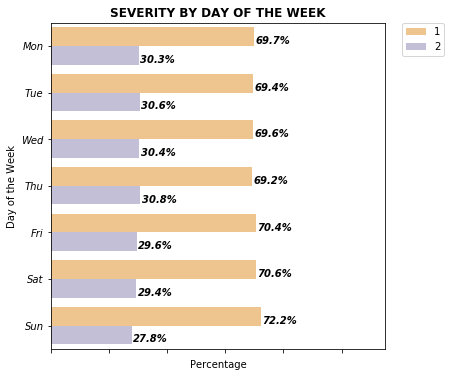

In [8]:
df['WEEKDAY'].replace( \
to_replace=(0,1,2,3,4,5,6), \
value=('Mon','Tue','Wed','Thu','Fri','Sat','Sun'), \
inplace=True)

temp= df.groupby(['WEEKDAY'])['SEVERITYCODE'].value_counts(normalize=True).mul(100).rename('percentage').reset_index().sort_index()
plt.figure(figsize=(6,6))
chart = sns.barplot(data = temp, x = 'percentage', y= 'WEEKDAY', hue= 'SEVERITYCODE', linewidth=2, palette='PuOr', order= ('Mon','Tue','Wed','Thu','Fri','Sat','Sun'))
chart.set_title('SEVERITY BY DAY OF THE WEEK', weight='bold')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_yticklabels(chart.get_yticklabels(), rotation=0, horizontalalignment='right', style='italic')
chart.set_xlabel('Percentage')
chart.set_ylabel('Day of the Week')
chart.set_xbound(upper=115)
# chart.set_ybound(lower=-1,upper=10)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

total=100
new_value=0.5
for p in chart.patches:
        percent = '{:.1f}%'.format(100 * p.get_width()/total)
        x =  p.get_width() + .5
        y = p.get_y() + p.get_height() - .05 
        chart.annotate(percent, (x, y), fontsize=10, color='k', weight='bold', style='italic')

df['WEEKDAY'].replace( \
value=(0,1,2,3,4,5,6), \
to_replace=('Mon','Tue','Wed','Thu','Fri','Sat','Sun'), \
inplace=True)

It can be seen as the day of the week doesn't imply any particular variation in the statistics of the incidents and that the evenience of critics/non critic accidents remains constant throughout the week. 

### WEATHER CONDITIONS
Before verifying the relation of the incidents during particular weather conditions per each district, I analyze the distribution of the weather conditions to see if they could be elaborated.

In [9]:
df['WEATHER'].value_counts(dropna=False)

Clear                       111135
Raining                      33145
Overcast                     27714
Unknown                      15091
NaN                           5081
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64

Now I can plot the percentage distribution of the kind of accidents given the different weather conditions

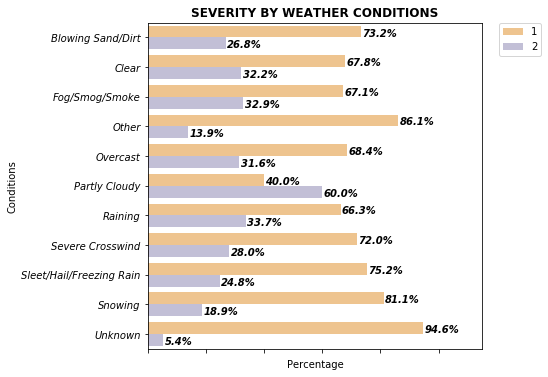

In [10]:
temp= df.groupby(['WEATHER'])['SEVERITYCODE'].value_counts(normalize=True).mul(100).rename('percentage').reset_index().sort_index()
plt.figure(figsize=(6,6))
chart = sns.barplot(data = temp, x = 'percentage', y= 'WEATHER', hue= 'SEVERITYCODE', linewidth=2, palette='PuOr')
chart.set_title('SEVERITY BY WEATHER CONDITIONS', weight='bold')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_yticklabels(chart.get_yticklabels(), rotation=0, horizontalalignment='right', style='italic')
chart.set_xlabel('Percentage')
chart.set_ylabel('Conditions')
chart.set_xbound(upper=115)
# chart.set_ybound(lower=-1,upper=10)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

total=100
new_value=0.5
for p in chart.patches:
        percent = '{:.1f}%'.format(100 * p.get_width()/total)
        x =  p.get_width() + .5
        y = p.get_y() + p.get_height() - .05 
        chart.annotate(percent, (x, y), fontsize=10, color='k', weight='bold', style='italic')


Given the size of the various conditions and the resemblance in percentage it is possible to gather the more little weather conditions together under the group 'Other' to reduce the dataset size.
Taking care of the nan values assimilating them under the 'Unknown' group.


### ROAD CONDITIONS
In this part the same approach used for the weather conditions is applied to the road ones

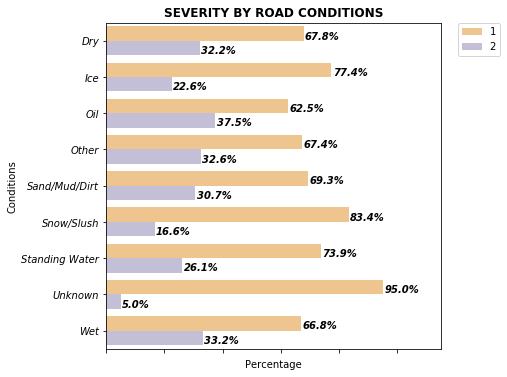

In [11]:
temp= df.groupby(['ROADCOND'])['SEVERITYCODE'].value_counts(normalize=True).mul(100).rename('percentage').reset_index().sort_index()
plt.figure(figsize=(6,6))
chart = sns.barplot(data = temp, x = 'percentage', y= 'ROADCOND', hue= 'SEVERITYCODE', linewidth=2, palette='PuOr')
chart.set_title('SEVERITY BY ROAD CONDITIONS', weight='bold')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_yticklabels(chart.get_yticklabels(), rotation=0, horizontalalignment='right', style='italic')
chart.set_xlabel('Percentage')
chart.set_ylabel('Conditions')
chart.set_xbound(upper=115)
# chart.set_ybound(lower=-1,upper=10)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

total=100
new_value=0.5
for p in chart.patches:
        percent = '{:.1f}%'.format(100 * p.get_width()/total)
        x =  p.get_width() + .5
        y = p.get_y() + p.get_height() - .05 
        chart.annotate(percent, (x, y), fontsize=10, color='k', weight='bold', style='italic')

It is possible to categorize the conditions into groups that comprehend two or more that share the same percentages.

    1. The NaN values are classified as 'Unknown'
    2. The 'Dry' and 'Wet' conditions presenting the same distribution are grouped together
    3. The 'Ice' and 'Snow/Slush' conditions too can be assembled
    4. The remaining small groups are collected as part of the 'Other' group


### LIGHT CONDITIONS


In [12]:
df['LIGHTCOND'].value_counts()

Daylight                    116137
Dark - Street Lights On      48507
Unknown                      13473
Dusk                          5902
Dawn                          2502
Dark - No Street Lights       1537
Dark - Street Lights Off      1199
Other                          235
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64

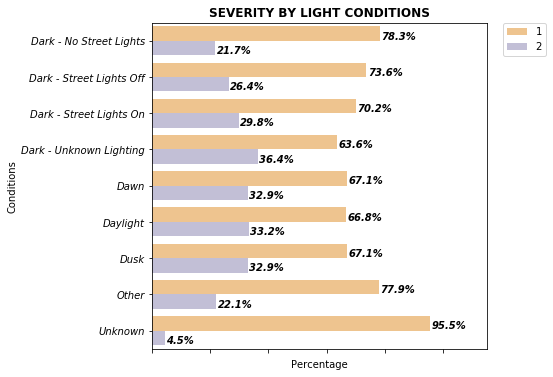

In [13]:
temp= df.groupby(['LIGHTCOND'])['SEVERITYCODE'].value_counts(normalize=True).mul(100).rename('percentage').reset_index().sort_index()
plt.figure(figsize=(6,6))
chart = sns.barplot(data = temp, x = 'percentage', y= 'LIGHTCOND', hue= 'SEVERITYCODE', linewidth=2, palette='PuOr')
chart.set_title('SEVERITY BY LIGHT CONDITIONS', weight='bold')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_yticklabels(chart.get_yticklabels(), rotation=0, horizontalalignment='right', style='italic')
chart.set_xlabel('Percentage')
chart.set_ylabel('Conditions')
chart.set_xbound(upper=115)
# chart.set_ybound(lower=-1,upper=10)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

total=100
new_value=0.5
for p in chart.patches:
        percent = '{:.1f}%'.format(100 * p.get_width()/total)
        x =  p.get_width() + .5
        y = p.get_y() + p.get_height() - .05 
        chart.annotate(percent, (x, y), fontsize=10, color='k', weight='bold', style='italic')

It is possible to categorize the conditions into groups that comprehend two or more that share the same percentages.

    1. The NaN values are classified as 'Unknown'
    2. The Dark related columns Values are classified as 'Dark'
    3. The Light related columns Values are classified as 'Light'

### INCIDENT LOCATION
This sections compare the different incidents ditribution according to the kind of location where the latter took place

In [14]:
df['ADDRTYPE'].value_counts(dropna=False)
df['ADDRTYPE'].replace(np.nan,'Unknown',inplace=True)

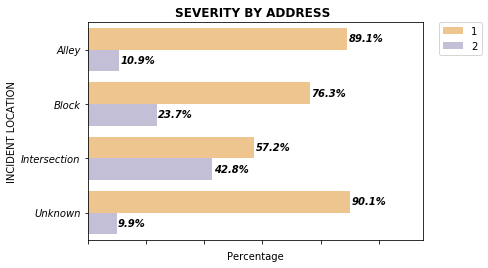

In [15]:
temp= df.groupby(['ADDRTYPE'])['SEVERITYCODE'].value_counts(normalize=True).mul(100).rename('percentage').reset_index().sort_index()

plt.figure()
chart = sns.barplot(data = temp, x = 'percentage', y= 'ADDRTYPE', hue= 'SEVERITYCODE', linewidth=2, palette='PuOr')
chart.set_title('SEVERITY BY ADDRESS ', weight='bold')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_yticklabels(chart.get_yticklabels(), rotation=0, horizontalalignment='right', style='italic')
chart.set_xlabel('Percentage')
chart.set_ylabel('INCIDENT LOCATION')
chart.set_xbound(upper=115)
# chart.set_ybound(lower=-1,upper=10)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

total=100
new_value=0.5
for p in chart.patches:
        percent = '{:.1f}%'.format(100 * p.get_width()/total)
        x =  p.get_width() + .5
        y = p.get_y() + p.get_height() - .15 
        chart.annotate(percent, (x, y), fontsize=10, color='k', weight='bold', style='italic')

By the graph is clear as 'Unknown' and 'Alley' values share same percentages together with having the same low number of cases and thus they can be collected as one


### COLLISION TYPE

In [16]:
df['COLLISIONTYPE'].value_counts(dropna=False)

Parked Car    47987
Angles        34674
Rear Ended    34090
Other         23703
Sideswipe     18609
Left Turn     13703
Pedestrian     6608
Cycles         5415
NaN            4904
Right Turn     2956
Head On        2024
Name: COLLISIONTYPE, dtype: int64

To convert the NaN values the 'SDOT_COLDESC' Column is used.
Values taken from the column help in filling the NaN in a proper way

In [17]:
# Transform Collision Type Column 
    # Pedestrian
mask_pedestrian = \
(df['COLLISIONTYPE'].isnull()) & \
(df['SDOT_COLDESC'].str.contains('PEDESTRIAN'))

df['COLLISIONTYPE'][mask_pedestrian] = 'Pedestrian'

# Cyclist
mask_cyclist = \
(df['COLLISIONTYPE'].isnull()) & \
(df['SDOT_COLDESC'].str.contains('PEDALCYCLIST'))

df['COLLISIONTYPE'][mask_cyclist] = 'Cycles'

# Angles 
mask_angles = \
(df['COLLISIONTYPE'].isnull()) & \
(df['SDOT_COLDESC'].str.contains('ANGLE'))

df['COLLISIONTYPE'][mask_angles] = 'Angles'

# Rear End 
mask_rearend = \
(df['COLLISIONTYPE'].isnull()) & \
(df['SDOT_COLDESC'].str.contains('REAR END'))

df['COLLISIONTYPE'][mask_rearend] = 'Rear End'

# Sideswipe
mask_sideswipe = \
(df['COLLISIONTYPE'].isnull()) & \
(df['SDOT_COLDESC'].str.contains('SIDESWIPE'))

df['COLLISIONTYPE'][mask_sideswipe] = 'Sideswipe'

# Other 
df['COLLISIONTYPE'].fillna('Other', inplace=True)

Once the NaN values are taken care of the next step is to simplify the data associated with the 'COLLISIONTYPE' column

In [18]:
df['COLLISIONTYPE'].value_counts()

Parked Car    47987
Angles        36651
Rear Ended    34090
Other         24694
Sideswipe     18765
Left Turn     13703
Pedestrian     6735
Cycles         5524
Right Turn     2956
Head On        2024
Rear End       1544
Name: COLLISIONTYPE, dtype: int64

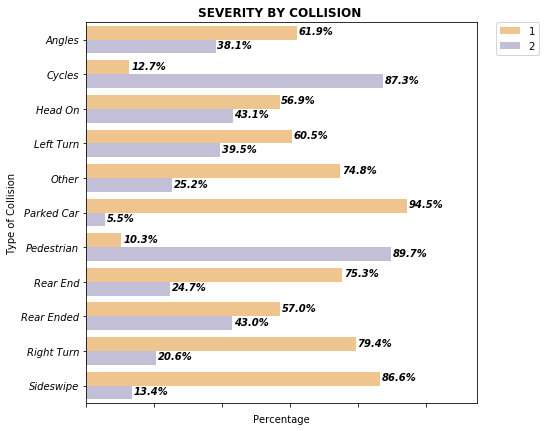

In [19]:
temp= df.groupby(['COLLISIONTYPE'])['SEVERITYCODE'].value_counts(normalize=True).mul(100).rename('percentage').reset_index().sort_index()

plt.figure(figsize=(7,7))
chart = sns.barplot(data = temp, x = 'percentage', y= 'COLLISIONTYPE', hue= 'SEVERITYCODE', linewidth=2, palette='PuOr')
chart.set_title('SEVERITY BY COLLISION ', weight='bold')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_yticklabels(chart.get_yticklabels(), rotation=0, horizontalalignment='right', style='italic')
chart.set_xlabel('Percentage')
chart.set_ylabel('Type of Collision')
chart.set_xbound(upper=115)
# chart.set_ybound(lower=-1,upper=10)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

total=100
new_value=0.5
for p in chart.patches:
        percent = '{:.1f}%'.format(100 * p.get_width()/total)
        x =  p.get_width() + .5
        y = p.get_y() + p.get_height() - .15 
        chart.annotate(percent, (x, y), fontsize=10, color='k', weight='bold', style='italic')

Given graph and value counts for the 'COLLISIONTYPE' column it is possible to group some of the characteristics that share same percentages

    - 'Pedestrian' and 'Cycles' incidents are regrouped as 'Ped/Cyc'
    - 'Angles' and 'Left turn' can be regrouped as the 'Angle/Left' group
    - 'Head On' and 'Rear Ended' become 'Front/Rear'


### NUMBER OF VEHICLES INVOLVED IN THE ACCIDENT

In [20]:
df['VEHCOUNT'].value_counts(dropna=False)

2     147650
1      25748
3      13010
0       5085
4       2426
5        529
6        146
7         46
8         15
9          9
11         6
10         2
12         1
Name: VEHCOUNT, dtype: int64

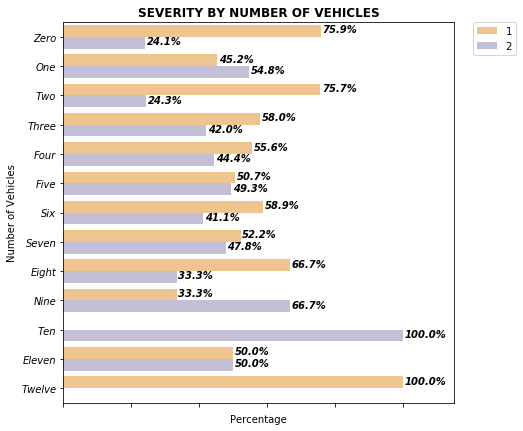

In [21]:
df['VEHCOUNT'].replace( \
to_replace=(0,1,2,3,4,5,6,7,8,9,10,11,12), \
value=('Zero','One','Two','Three','Four','Five','Six','Seven','Eight','Nine','Ten','Eleven','Twelve'), \
inplace=True)

temp= df.groupby(['VEHCOUNT'])['SEVERITYCODE'].value_counts(normalize=True).mul(100).rename('percentage').reset_index().sort_index()

plt.figure(figsize=(7,7))
chart = sns.barplot(data = temp, x = 'percentage', y= 'VEHCOUNT', hue= 'SEVERITYCODE', linewidth=2,palette='PuOr', \
order=('Zero','One','Two','Three','Four','Five','Six','Seven','Eight','Nine','Ten','Eleven','Twelve'))

chart.set_title('SEVERITY BY NUMBER OF VEHICLES', weight='bold')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_yticklabels(chart.get_yticklabels(), rotation=0, horizontalalignment='right', style='italic')
chart.set_xlabel('Percentage')
chart.set_ylabel('Number of Vehicles')
chart.set_xbound(upper=115)
# chart.set_ybound(lower=-1,upper=10)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

total=100
new_value=0.5
for p in chart.patches:
        percent = '{:.1f}%'.format(100 * p.get_width()/total)
        x =  p.get_width() + .5
        y = p.get_y() + p.get_height() - .15 
        chart.annotate(percent, (x, y), fontsize=10, color='k', weight='bold', style='italic')

df['VEHCOUNT'].replace( \
value=(0,1,2,3,4,5,6,7,8,9,10,11,12), \
to_replace=('Zero','One','Two','Three','Four','Five','Six','Seven','Eight','Nine','Ten','Eleven','Twelve'),\
inplace=True)

From the percentage graph and the info from the groupby text it is possible to group all accidents that involve more than 3 cars under the same category.
It has to be noted that even if higher number o vehicles included in the accident don't show a percentage similar to the others the low amount of cases makes it difficult to build a reliable statistic.
Given these conditions it is safe to assume that accidents that involved more than three cars can be considered critic.

### NUMBER OF PEDESTRIANS INVOLVED IN THE ACCIDENT 
Relationship between the severity of the accident and the number of pedestrians involved  

In [22]:
df['PEDCOUNT'].value_counts(dropna=False)

0    187734
1      6685
2       226
3        22
4         4
6         1
5         1
Name: PEDCOUNT, dtype: int64

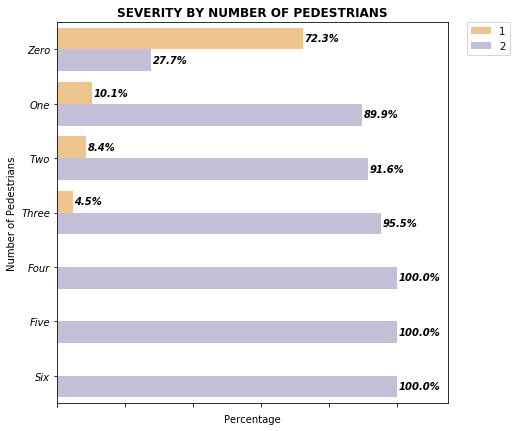

In [23]:
df['PEDCOUNT'].replace( \
to_replace=(0,1,2,3,4,5,6), \
value=('Zero','One','Two','Three','Four','Five','Six'), \
inplace=True)

temp= df.groupby(['PEDCOUNT'])['SEVERITYCODE'].value_counts(normalize=True).mul(100).rename('percentage').reset_index().sort_index()

plt.figure(figsize=(7,7))
chart = sns.barplot(data = temp, x = 'percentage', y= 'PEDCOUNT', hue= 'SEVERITYCODE', linewidth=2, palette='PuOr', order=('Zero','One','Two','Three','Four','Five','Six'))
chart.set_title('SEVERITY BY NUMBER OF PEDESTRIANS', weight='bold')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_yticklabels(chart.get_yticklabels(), rotation=0, horizontalalignment='right', style='italic')
chart.set_xlabel('Percentage')
chart.set_ylabel('Number of Pedestrians')
chart.set_xbound(upper=115)
# chart.set_ybound(lower=-1,upper=10)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

total=100
new_value=0.5
for p in chart.patches:
        percent = '{:.1f}%'.format(100 * p.get_width()/total)
        x =  p.get_width() + .5
        y = p.get_y() + p.get_height() - .15 
        chart.annotate(percent, (x, y), fontsize=10, color='k', weight='bold', style='italic')

df['PEDCOUNT'].replace( \
to_replace=('Zero','One','Two','Three','Four','Five','Six'), \
value=(0,1,2,3,4,5,6), \
inplace=True)

The graph shows clearly as whenever a pedestrian is involved there's a high chance for the incident to be critic.
The 'PEDCOUNT' column can be then considered as a boolean.
The column will display one if at least one pedestrian is involved and zero otherwise.

### NUMBER OF CYCLISTS INVOLVED IN THE ACCIDENT
Relationship between the severity of the accident and the number of cyclists involved 

In [24]:
df['PEDCYLCOUNT'].value_counts(dropna=False)

0    189189
1      5441
2        43
Name: PEDCYLCOUNT, dtype: int64

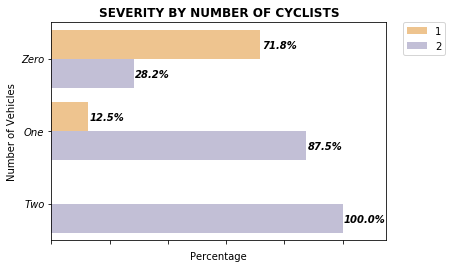

In [25]:
df['PEDCYLCOUNT'].replace( \
to_replace=(0,1,2), \
value=('Zero','One','Two'), \
inplace=True)

temp= df.groupby(['PEDCYLCOUNT'])['SEVERITYCODE'].value_counts(normalize=True).mul(100).rename('percentage').reset_index().sort_index()
plt.figure()
chart = sns.barplot(data = temp, x = 'percentage', y= 'PEDCYLCOUNT', hue= 'SEVERITYCODE', linewidth=2, palette='PuOr', order=('Zero','One','Two'))
chart.set_title('SEVERITY BY NUMBER OF CYCLISTS', weight='bold')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_yticklabels(chart.get_yticklabels(), rotation=0, horizontalalignment='right', style='italic')
chart.set_xlabel('Percentage')
chart.set_ylabel('Number of Vehicles')
chart.set_xbound(upper=115)
# chart.set_ybound(lower=-1,upper=10)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

total=100
new_value=0.5
for p in chart.patches:
        percent = '{:.1f}%'.format(100 * p.get_width()/total)
        x =  p.get_width() + .5
        y = p.get_y() + p.get_height() - .15 
        chart.annotate(percent, (x, y), fontsize=10, color='k', weight='bold', style='italic')

df['PEDCYLCOUNT'].replace( \
to_replace=('Zero','One','Two'), \
value=(0,1,2), \
inplace=True)

The graph shows clearly as when a cyclist is involved the incident has a high chance to be critic. The  'PEDCYLCOUNT' column can be then considered as a boolean giving one if cyclists are involved and zero otherwise.

### NUMBER OF PEOPLE INVOLVED IN THE ACCIDENT

In [26]:
df['PERSONCOUNT'].value_counts(dropna=False)

2     114231
3      35553
4      14660
1      13154
5       6584
0       5544
6       2702
7       1131
8        533
9        216
10       128
11        56
12        33
13        21
14        19
15        11
17        11
16         8
44         6
18         6
20         6
25         6
19         5
26         4
22         4
27         3
28         3
29         3
47         3
32         3
34         3
37         3
23         2
21         2
24         2
30         2
36         2
57         1
31         1
35         1
39         1
41         1
43         1
48         1
53         1
54         1
81         1
Name: PERSONCOUNT, dtype: int64

Given the results all the cases that include more than six people can be considered under the same group.
The low amount of cases that concern more than 6 people makes difficult to build a clear statistic hence it is safe to take this approach and to think that accidents that included more than 6 people can be considered critic.

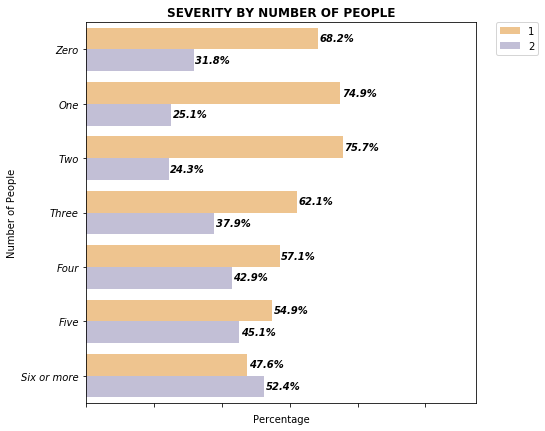

In [27]:
df['PERSONCOUNT'][df['PERSONCOUNT']>= 6] = 'Six or more'

df['PERSONCOUNT'].replace( \
to_replace=(0,1,2,3,4,5), \
value=('Zero','One','Two','Three','Four','Five'), \
inplace=True)

temp= df.groupby(['PERSONCOUNT'])['SEVERITYCODE'].value_counts(normalize=True).mul(100).rename('percentage').reset_index().sort_index()

plt.figure(figsize=(7,7))
chart = sns.barplot(data = temp, x = 'percentage', y= 'PERSONCOUNT', hue= 'SEVERITYCODE', linewidth=2, palette='PuOr', order=('Zero','One','Two','Three','Four','Five','Six or more'))
chart.set_title('SEVERITY BY NUMBER OF PEOPLE', weight='bold')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_yticklabels(chart.get_yticklabels(), rotation=0, horizontalalignment='right', style='italic')
chart.set_xlabel('Percentage')
chart.set_ylabel('Number of People')
chart.set_xbound(upper=115)
# chart.set_ybound(lower=-1,upper=10)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

total=100
new_value=0.5
for p in chart.patches:
        percent = '{:.1f}%'.format(100 * p.get_width()/total)
        x =  p.get_width() + .5
        y = p.get_y() + p.get_height() - .15 
        chart.annotate(percent, (x, y), fontsize=10, color='k', weight='bold', style='italic')

df['PERSONCOUNT'].replace( \
value=(0,1,2,3,4,5,'6 or more'), \
to_replace=('Zero','One','Two','Three','Four','Five','Six or more'), \
inplace=True)

The graphs shows that there are groups that share similar percentages and thus can be grouped together as the groups 1,2 and 4,5.

## DATA PREPARATION
All the observations extrapolated from the previous graph and data analysis are applied in the next phase.
The dataset that is going to be obtained at the end of this phase will be fed to the MODELING PHASE.

### WEATHER

In [28]:
df['WEATHER'].replace(to_replace= ('Sleet/Hail/Freezing Rain', 'Blowing Sand/Dirt', 'Severe Crosswind',                 'Partly Cloudy', 'Snowing'), value='Other', inplace=True)
df['WEATHER'].replace(to_replace= np.nan, value='Unknown', inplace=True)
df['WEATHER'].value_counts()

Clear             111135
Raining            33145
Overcast           27714
Unknown            20172
Other               1938
Fog/Smog/Smoke       569
Name: WEATHER, dtype: int64

### ROAD CONDITIONS

In [29]:
df['ROADCOND'].replace(to_replace= np.nan,value='Unknown',inplace=True)
df['ROADCOND'].replace(to_replace=('Dry', 'Wet'), value='Dry/Wet',inplace=True)
df['ROADCOND'].replace(to_replace=('Ice', 'Snow/Slush'), value='Ice/Snow',inplace=True)
df['ROADCOND'].replace(to_replace=('Standing Water', 'Sand/Mud/Dirt', 'Oil'), value='Other',inplace=True)

### LIGHT CONDITIONS

In [30]:
df['LIGHTCOND'].replace(to_replace= np.nan,value='Unknown', inplace=True)
df['LIGHTCOND'].replace(to_replace=('Dawn', 'Dusk', 'Daylight'), value='Light', inplace=True)
df['LIGHTCOND'].replace(to_replace=('Dark - Street Lights On', 'Dark - No Street Lights',
'Dark - Street Lights Off', 'Dark - Unknown Lighting'), value='Dark', inplace=True)

### ADDRESS TYPE

In [31]:
df['ADDRTYPE'].replace(to_replace='Unknown', value='Alley', inplace=True)

### COLLISION TYPE

In [32]:
df['COLLISIONTYPE'].replace(to_replace=('Head On', 'Rear Ended'), value= 'Front/Rear', inplace=True)
df['COLLISIONTYPE'].replace(to_replace=('Pedestrian', 'Cycles'),  value= 'Ped/Cyc',    inplace=True)
df['COLLISIONTYPE'].replace(to_replace=('Angles', 'Left Turn'),   value= 'Angle/Left', inplace=True) 

### NUMBER OF VEHICLES INVOLVED IN THE ACCIDENT

In [33]:
df['VEHCOUNT'][df['VEHCOUNT']>3] = '3 or more'

### NUMBER OF PEDESTRIANS INVOLVED IN THE ACCIDENT

In [34]:
df['PEDCOUNT'][df['PEDCOUNT']>1] = 1

### NUMBER OF CYCLISTS INVOLVED IN THE ACCIDENT

In [35]:
df['PEDCYLCOUNT'][df['PEDCYLCOUNT']>1] = 1

### NUMBER OF PEOPLE INVOLVED IN THE ACCIDENT 

In [36]:
df['PERSONCOUNT'][df['PERSONCOUNT']== 0] = '0'
df['PERSONCOUNT'][df['PERSONCOUNT']== 3] = '3'
df['PERSONCOUNT'][(df['PERSONCOUNT']==4)|(df['PERSONCOUNT']==5)] = '4/5'
df['PERSONCOUNT'][(df['PERSONCOUNT']==1)|(df['PERSONCOUNT']==2)] = '1/2'

Once the data are transformed and simplified they are converted so to be usable by the model.
First the columns that don't add any useful information are removed

In [37]:
# df.drop(['JUNCTIONTYPE', 'SDOT_COLDESC', 'UNDERINFL', 'ST_COLDESC','HITPARKEDCAR', 'geometry'], axis = 1, inplace = True)

df.drop(['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO','STATUS', 'INTKEY', 'LOCATION',  'EXCEPTRSNCODE', 'EXCEPTRSNDESC','SEVERITYCODE.1', 'SEVERITYDESC','INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC','INATTENTIONIND', 'UNDERINFL','PEDROWNOTGRNT', 'SDOTCOLNUM','SPEEDING','ST_COLCODE','ST_COLDESC','SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR', 'geometry', ], 
axis = 1, inplace = True)
df.info()

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 12 columns):
SEVERITYCODE     194673 non-null int64
ADDRTYPE         194673 non-null object
COLLISIONTYPE    194673 non-null object
PERSONCOUNT      194673 non-null object
PEDCOUNT         194673 non-null int64
PEDCYLCOUNT      194673 non-null int64
VEHCOUNT         194673 non-null object
WEATHER          194673 non-null object
ROADCOND         194673 non-null object
LIGHTCOND        194673 non-null object
DISTRICT         188057 non-null float64
WEEKDAY          194673 non-null int64
dtypes: float64(1), int64(4), object(7)
memory usage: 12.6+ MB


In [38]:
df.to_csv("D:/personale/MACHINELEARNING/IBM/capstone/file_for_graphs.csv")


After this passage the data are transformed from text to boolean columns of 0 and 1.

In [39]:
df = pd.get_dummies(df, columns= ['COLLISIONTYPE'])
df = pd.get_dummies(df, columns= ['ADDRTYPE'])
df = pd.get_dummies(df, columns= ['WEATHER'])
df = pd.get_dummies(df, columns= ['LIGHTCOND'])
df = pd.get_dummies(df, columns= ['ROADCOND'])
df = pd.get_dummies(df, columns= ['PERSONCOUNT'])
df = pd.get_dummies(df, columns= ['DISTRICT'])

df['VEHCOUNT'].replace( to_replace=(0,1,2,3), value=('0','1','2','3 or more'), inplace = True)
df = pd.get_dummies(df, columns= ['VEHCOUNT'])

## MODELING PHASE 

In this phase a model is built that could reproduce the results.
Being the problem a classification one based on unbiased dataset a logistic regression algorithm will be implemented.
For first the dataset is split into a train and test part.

In [40]:
from sklearn.model_selection import train_test_split

y = df['SEVERITYCODE']
df.drop('SEVERITYCODE', axis= 1, inplace= True)

X_train, X_test, y_train, y_test = train_test_split( df, y, test_size=0.2, random_state=10)

Secondly the logistic regression algorithm is applied to solve the binary classification problem

In [41]:
import scipy.optimize as opt
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.001, solver='liblinear', max_iter=20000).fit(X_train,y_train)
yhat = LR.predict(X_test)

## MODEL EVALUATION 

Having to deal with an unbiased data set the measurement of the accuracy of the model is done applying the F-SCORE analysis.

In [44]:
from sklearn.metrics import f1_score, jaccard_score
f_score = f1_score(y_test, yhat)
j_score = jaccard_score(y_test, yhat)
print('Logistic Regression F1 score: ', f_score)

Logistic Regression F1 score:  0.8451668650243735


It can be seen as the F-Score value obtained lies around the 0.85.

## MODEL DEPLOYMENT

Once the model is accepted it can be put in act on the street analyzing the conditions present at the moment of the accident.
The feeding of these info to the model makes possible to obtain an immediate answer about the criticity of the event and give more time to the interested entities such as hospital, policemens etc.. to activate and response in a fast and proper way to the emergency.